In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extreme Gradient Boost

[XBOOST](https://xgboost.readthedocs.io/en/stable/)

In [2]:
try:
    import xgboost as xgb
except:
    %pip install xgboost
    import xgboost as xgb

In [3]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_date="data/processed_data/daily_solar_data.feather"


In [4]:
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_date)

In [5]:
print(f'df_enriched_features columns {df_enriched_features.columns.to_list()}')
print(f'df_weather_data {df_weather_data.columns.to_list()}')
print(f'df_solar_data {df_solar_data.columns.to_list()}')

df_enriched_features columns ['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date']
df_weather_data ['DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code']
df_solar_data ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime']


In [6]:
# merge all the 3 dataframes on DateTime
df_merge = df_solar_data.merge(right=df_weather_data,how='inner',left_on='DateTime',right_on='DateTime')
df_merge = df_merge.merge(right=df_enriched_features,how='inner',left_on='DateTime',right_on='DateTime')
# convert DateTime to datetime
df_merge['DateTime'] = pd.to_datetime(df_merge['DateTime'])
df_merge['Month_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.month - 1) / 12)
df_merge['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.dayofyear - 1) / 365)
df_merge['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge['DateTime'].dt.hour) / 24)
print(f"df_merge  {df_merge.columns.to_list()}")
print(f"df_merge  {df_merge.shape}")

df_merge  ['Date_x', 'Number', 'Time_x', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time_y', 'Date_y', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
df_merge  (59110, 32)


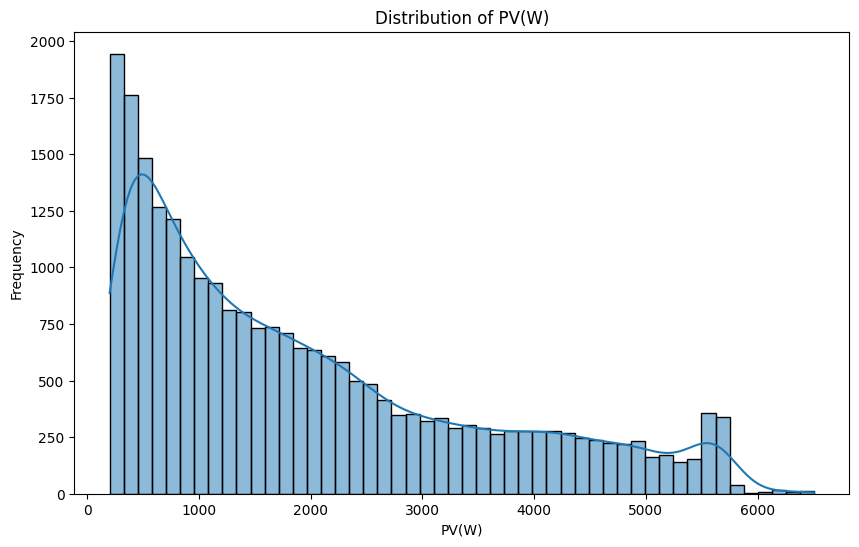

In [7]:
# plot a histogram of the target variable PV(W)
plt.figure(figsize=(10,6))
sns.histplot(df_merge['PV(W)'][df_merge['PV(W)']>200], bins=50, kde=True)
plt.title('Distribution of PV(W)')
plt.xlabel('PV(W)')
plt.ylabel('Frequency')
plt.show()

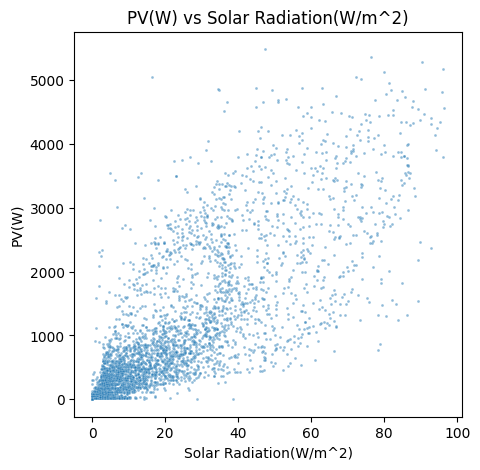

In [8]:
# create a scatter plot of PV(W) vs Solar Radiation(W/m^2)
from datetime import date
plt.figure(figsize=(5,5))
# filter the date range for the scatter plot to be between 2025-01-01 and 2025-01-31 using date type comparison
start_date = date(2025, 1, 1)
end_date = date(2025, 3, 15)
# convert string to date type



sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= start_date) & (df_merge['Date_y'] <= end_date)], alpha=0.5, s=4)
plt.title('PV(W) vs Solar Radiation(W/m^2)')
plt.xlabel('Solar Radiation(W/m^2)')
#sns.scatterplot(x='GHI', y='PV(W)', data=df_merge[(df_merge['Date_y'] >= date(2025, 3,14)) & (df_merge['Date_y'] <= date(2025, 8,20))], alpha=0.5, s=4)
#plt.title('PV(W) vs Solar Radiation(W/m^2)')
#plt.xlabel('Solar Radiation(W/m^2)')
#plt.ylabel('PV(W)')
plt.ylabel('PV(W)')
plt.show()

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Definining Features")
# 1. Define Features (X) and Target (y)
# Dropping 'DateTime' as XGBoost needs numerical inputs, and 'PV(W)' because it's the target
features = ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 
            'Condition Code',  'DayOfYear_Sin', 'HourOfDay_Sin', 'Clear sky GHI']
target = 'PV(W)'
print("Definining x and y")
X = df_merge[features][df_merge['PV(W)']>200]
y = df_merge[target][df_merge['PV(W)']>200]
print("Splitting")
# 2. Split into Train and Test sets (80% Train, 20% Test)
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Definining Features
Definining x and y
Splitting
Training samples: 19770
Testing samples: 4943


In [10]:
# 3. Initialize XGBoost Regressor
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage used to prevent overfitting
# max_depth: Maximum depth of a tree
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          n_estimators=100, 
                          learning_rate=0.1, 
                          max_depth=5, 
                          random_state=42,
                      #    enable_categorical=True,  # Tell XGBoost to handle categories
                      #      tree_method='hist'        # 'hist' works best with categorical data
                          )

# 4. Fit the model
print("Training XGBoost model...")
xg_reg.fit(X_train, y_train)
# save model
xg_reg.save_model("solar_xboost.json")
print("Training complete.")

Training XGBoost model...
Training complete.


In [11]:
# 5. Make Predictions
from sklearn.metrics import mean_absolute_percentage_error

y_pred = xg_reg.predict(X_test)

# 6. Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} W")
print(f"Mean Absolute Error (MAE): {mae:.2f} W")
print(f"Mean Absolute Percentage Error (MAPE) {mape:.2f} %")
# Workk out MAPE


Root Mean Squared Error (RMSE): 829.18 W
Mean Absolute Error (MAE): 567.47 W
Mean Absolute Percentage Error (MAPE) 0.44 %


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

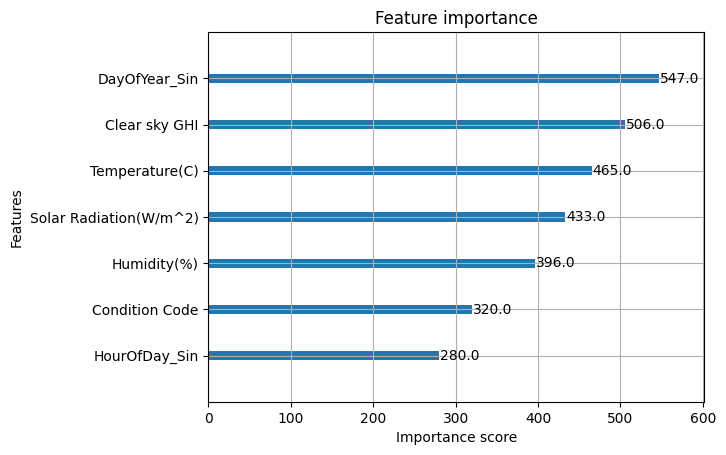

In [12]:
xgb.plot_importance(xg_reg)

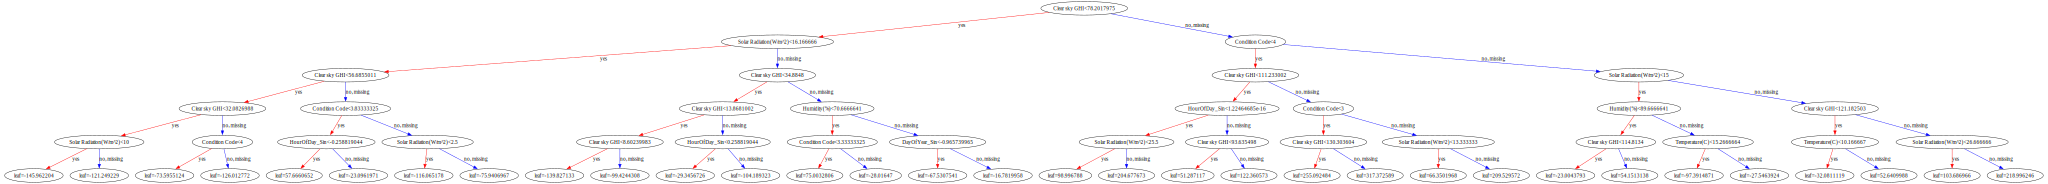

In [13]:
try:
    import graphviz
except: 
    %pip install graphviz
    import graphviz

#xgb.plot_tree(xg_reg)
xgb.to_graphviz(xg_reg)

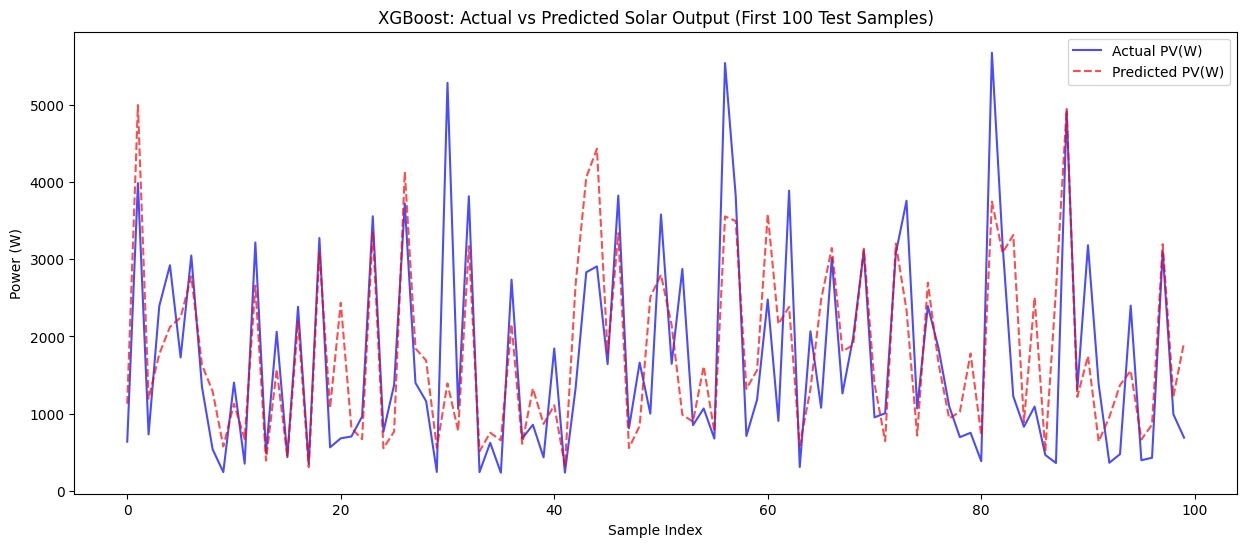

<Figure size 1000x600 with 0 Axes>

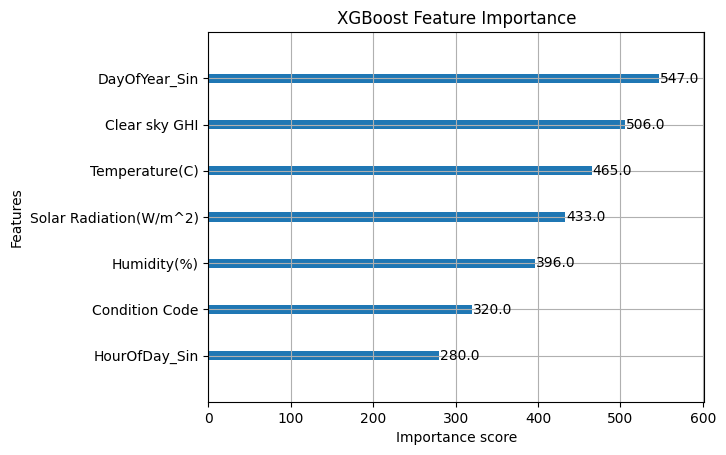

In [14]:


# 7. Visualize Actual vs Predicted (First 100 test points for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 8. Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

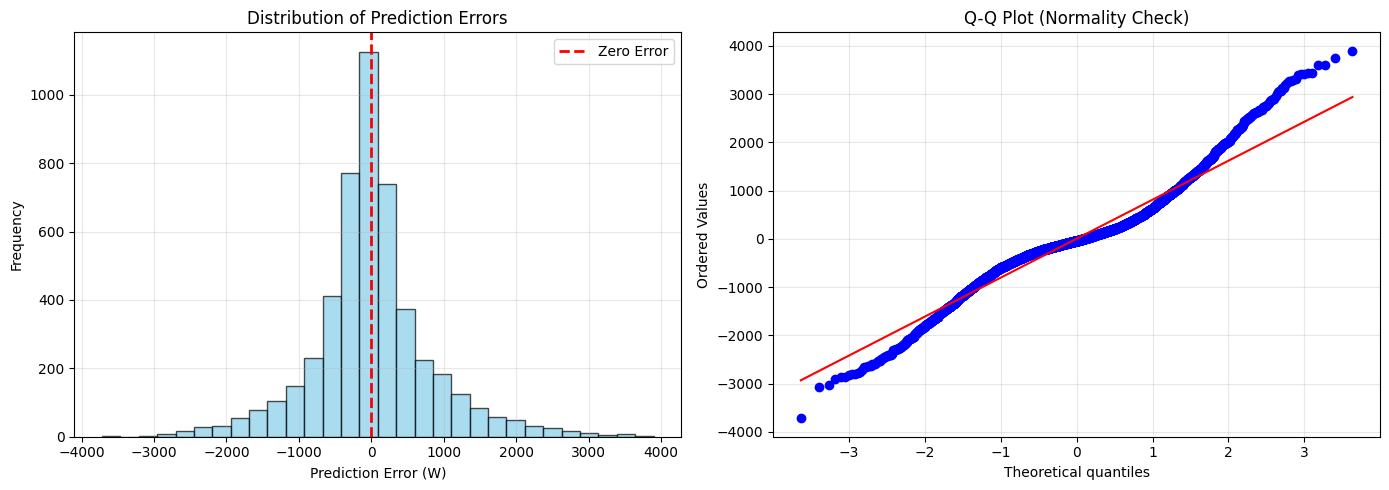

Error Mean: 3.57 W
Error Std Dev: 829.17 W
Error Min: -3719.09 W
Error Max: 3897.91 W


In [15]:
# plot error distribution
# plot error distribution
errors = y_test.values - y_pred

plt.figure(figsize=(14, 5))

# Histogram of errors
plt.subplot(1, 2, 1)
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)

# Q-Q plot for normality check
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"Error Mean: {errors.mean():.2f} W")
print(f"Error Std Dev: {errors.std():.2f} W")
print(f"Error Min: {errors.min():.2f} W")
print(f"Error Max: {errors.max():.2f} W")